In [224]:
#!pip install scanpy
#!pip install pybiomart
#!pip install scrublet
#!pip3 install leidenalg

## Bring In Sample Data

In [225]:
!mkdir -p demodata

This notebook is written based on a set of Bone Marrow Cell Data downloaded from Terra.

To copy the data from the Google Cloud, add the Google SDK toolkit to your bash.

In [226]:
#!gsutil -m cp -r gs://terra-featured-workspaces/Cumulus/cellranger_output ./demodata

In [227]:
import numpy as np
import pandas as pd
import scanpy as sc


sc.settings.verbosity = 0

In [228]:
sc.settings.set_figure_params(dpi=80)

In [229]:
!ls -d demodata/cellranger_output/*

demodata/cellranger_output/MantonBM1_HiSeq_1
demodata/cellranger_output/MantonBM2_HiSeq_1
demodata/cellranger_output/MantonBM3_HiSeq_1
demodata/cellranger_output/MantonBM4_HiSeq_1
demodata/cellranger_output/MantonBM5_HiSeq_1
demodata/cellranger_output/MantonBM6_HiSeq_1
demodata/cellranger_output/MantonBM7_HiSeq_1
demodata/cellranger_output/MantonBM8_HiSeq_1


In [230]:
#read in data

MantonBM1 = sc.read_10x_h5('demodata/cellranger_output/MantonBM1_HiSeq_1/raw_feature_bc_matrix.h5')
MantonBM1.var_names_make_unique()
MantonBM2 = sc.read_10x_h5('demodata/cellranger_output/MantonBM2_HiSeq_1/raw_feature_bc_matrix.h5')
MantonBM2.var_names_make_unique()
MantonBM3 = sc.read_10x_h5('demodata/cellranger_output/MantonBM3_HiSeq_1/raw_feature_bc_matrix.h5')
MantonBM3.var_names_make_unique()
MantonBM4 = sc.read_10x_h5('demodata/cellranger_output/MantonBM4_HiSeq_1/raw_feature_bc_matrix.h5')
MantonBM4.var_names_make_unique()
MantonBM5 = sc.read_10x_h5('demodata/cellranger_output/MantonBM5_HiSeq_1/raw_feature_bc_matrix.h5')
MantonBM5.var_names_make_unique()
MantonBM6 = sc.read_10x_h5('demodata/cellranger_output/MantonBM6_HiSeq_1/raw_feature_bc_matrix.h5')
MantonBM6.var_names_make_unique()

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [231]:
# add some metadata
MantonBM1.obs['type']="Female"
MantonBM1.obs['sample']="Female_BM1"
MantonBM2.obs['type']="Male"
MantonBM2.obs['sample']="Male_BM2"
MantonBM3.obs['type']="Male"
MantonBM3.obs['sample']="Male_BM3"
MantonBM4.obs['type']="Male"
MantonBM4.obs['sample']="Male_BM4"
MantonBM5.obs['type']="Male"
MantonBM5.obs['sample']="Male_BM5"
MantonBM6.obs['type']="Female"
MantonBM6.obs['sample']="Female_BM6"




In [232]:
# merge into one object.
adata = MantonBM1.concatenate(MantonBM2, MantonBM3, MantonBM4, MantonBM5, MantonBM6)



/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


## Print the Number of Observations Per Sample

In [233]:
print(adata.obs['sample'].value_counts())

adata

Male_BM5      340364
Female_BM6    323253
Female_BM1    302618
Male_BM2      281141
Male_BM4      280951
Male_BM3      270127
Name: sample, dtype: int64


AnnData object with n_obs × n_vars = 1798454 × 36601
    obs: 'type', 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

## Filter Cells and Genes

* Remove Cells that have Have Gene Expression levels below 500 and above 6000
* Remove Genes that are in less thatn 5% of the Cells



In [234]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

34754 27147


In [235]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

TODO: Filter out genes expressed in less than 5% of the cellls

## Find Occurrence of Mitochondrial and Ribosomal Genes

In [236]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

adata.var

,gene_ids,feature_types,genome,n_cells,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,mt,ribo,hb
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,3,3,0.000086,99.991368,3.0,False,False,False
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,28,28,0.000806,99.919434,28.0,False,False,False
AL627309.5,ENSG00000241860,Gene Expression,GRCh38,83,83,0.002388,99.761179,83.0,False,False,False
AP006222.2,ENSG00000286448,Gene Expression,GRCh38,7,7,0.000230,99.979858,8.0,False,False,False
LINC01409,ENSG00000237491,Gene Expression,GRCh38,1807,1807,0.059619,94.800598,2072.0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
AC240274.1,ENSG00000271254,Gene Expression,GRCh38,235,235,0.006848,99.323819,238.0,False,False,False
AC004556.3,ENSG00000276345,Gene Expression,GRCh38,8,8,0.000230,99.976981,8.0,False,False,False
AC233755.2,ENSG00000277856,Gene Expression,GRCh38,6,6,0.000317,99.982736,11.0,False,False,False
AC233755.1,ENSG00000275063,Gene Expression,GRCh38,15,15,0.000489,99.956840,17.0,False,False,False


In [237]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

In [238]:
# filter for gene detection
keep = (adata.obs['n_genes_by_counts'] < 6000) & (adata.obs['n_genes_by_counts'] > 500)

print(sum(keep))
adata = adata[keep, :]

print("Remaining cells %d"%adata.n_obs)

31617
Remaining cells 31617


In [239]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
np.seterr(invalid='ignore')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mt2'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  


Uncomment this cell to see the jitter plots for the samples.

In [240]:
#sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="sample")

In [241]:
#sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
 #            jitter=0.4, groupby = 'sample', rotation= 45,show=True)

#plt.savefig("demodata/mito_counts_violin.pdf")


In [242]:
# filter for percent mito

adata = adata[adata.obs['pct_counts_mt'] < 10, :]

# filter for percent ribo > 0.05
adata = adata[adata.obs['pct_counts_ribo'] > 5, :]

print("Remaining cells %d"%adata.n_obs)

Remaining cells 30488


In [243]:
#sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
 #            jitter=0.4, groupby = 'sample', rotation = 45)

## Filter out Technical Artifacts

In [244]:
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
mito_genes = adata.var_names.str.startswith('MT-')
hb_genes = adata.var_names.str.contains('^HB[^(P)]')

remove = np.add(mito_genes, malat1)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

30488 27121


In [245]:
#sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
  #           jitter=0.4, groupby = 'sample', rotation = 45)

/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


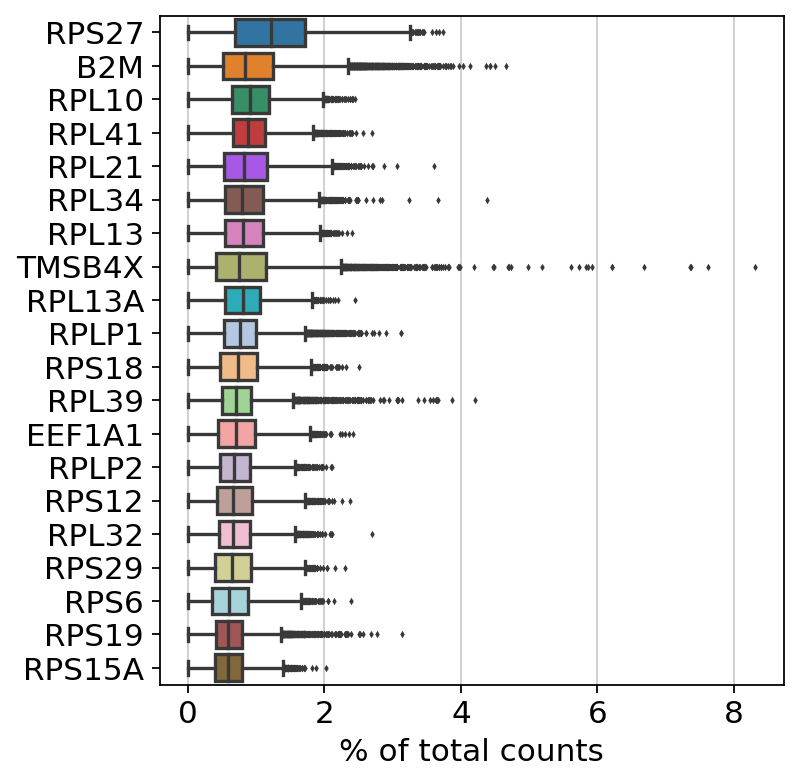

In [246]:
sc.pl.highest_expr_genes(adata, n_top=20)

## This section is optional 

This section looks at chrY markers and determines the likelihood of the gender of the sample origin.

This is the source of the metadata at the top of the notebook.

In [247]:
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("external_gene_name")
#>>> adata.var[annot.columns] = annot

In [248]:
chrY_genes = adata.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

Index(['RPS4Y1', 'ZFY', 'ZFY-AS1', 'LINC00278', 'PCDH11Y', 'AMELY', 'TBL1Y',
       'PRKY', 'USP9Y', 'DDX3Y', 'UTY', 'TMSB4Y', 'NLGN4Y', 'NLGN4Y-AS1',
       'FAM41AY1', 'FAM224B', 'FAM224A', 'FAM41AY2', 'TTTY14', 'KDM5D',
       'TTTY10', 'EIF1AY', 'RPS4Y2', 'TTTY4B'],
      dtype='object')

In [249]:
adata.obs['percent_chrY'] = np.sum(
    adata[:, chrY_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1 * 100

In [250]:
# color inputs must be from either .obs or .var, so add in XIST expression to obs.
adata.obs["XIST-counts"] = adata.X[:,adata.var_names.str.match('XIST')].toarray()

#sc.pl.scatter(adata, x='XIST-counts', y='percent_chrY', color="sample")

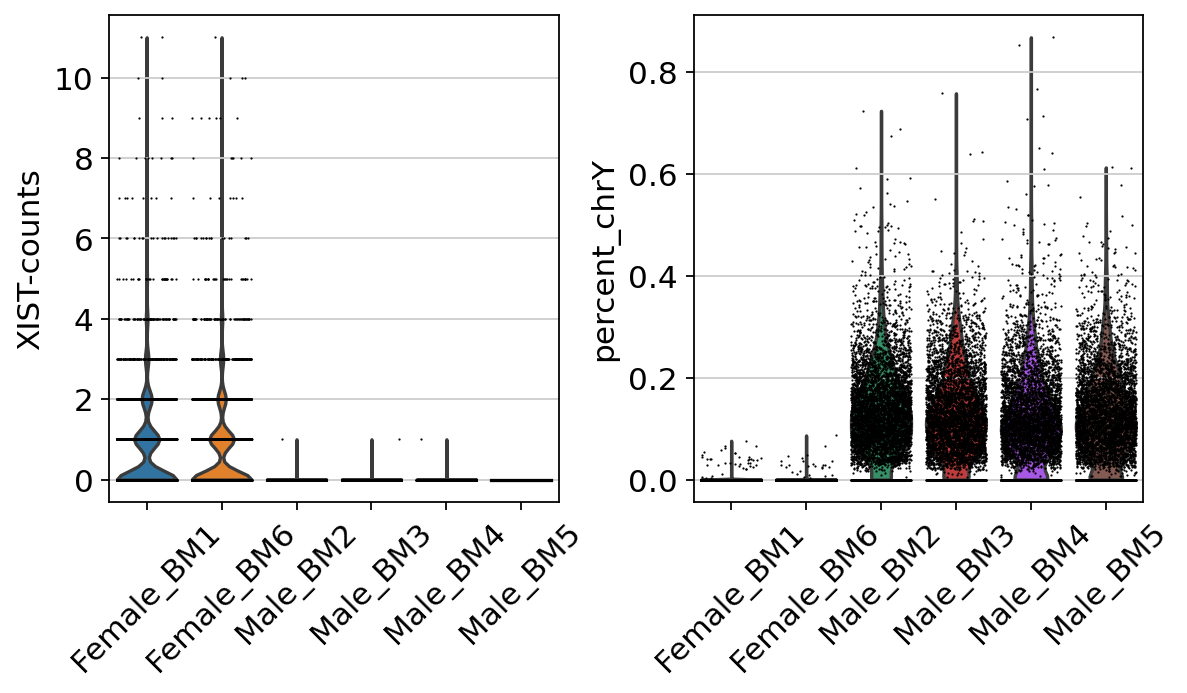

In [251]:

import matplotlib.pyplot as plt

sc.pl.violin(adata, ["XIST-counts", "percent_chrY"], jitter=0.4, groupby = 'sample', rotation= 45,show=False)

plt.savefig("demodata/gender_counts_violin.pdf")




## Cell Cycle Genes and extract Highly Expressed Genes

In [252]:
!if [ ! -f data/regev_lab_cell_cycle_genes.txt ]; \
then curl -o data/regev_lab_cell_cycle_genes.txt \
https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt;\
fi
    

In [253]:
cell_cycle_genes = [x.strip() for x in open('./data/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

97
94


### Log Normalize Data by 100,000 Reads Per Cell

In [254]:
sc.pp.filter_genes(adata, min_cells=1)
sc.pp.normalize_total(adata, target_sum=1e5)
sc.pp.log1p(adata)

print(adata.n_obs, adata.n_vars)

30488 27113


In [255]:
print(adata.n_obs, adata.n_vars)

30488 27113


In [256]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

In [257]:
#sc.pl.violin(adata, ['S_score', 'G2M_score'],
#             jitter=0.4, groupby = 'sample', rotation=45)

### Optional Demo on Doublets

In [258]:
#import scrublet as scr

# split per batch into new objects.
#batches = adata.obs['sample'].cat.categories.tolist()
#alldata = {}
#for batch in batches:
#    tmp = adata[adata.obs['sample'] == batch,]
#    print(batch, ":", tmp.shape[0], " cells")
#    scrub = scr.Scrublet(tmp.raw.X)
#    out = scrub.scrub_doublets(verbose=False, n_prin_comps = 20)
#    alldata[batch] = pd.DataFrame({'doublet_score':out[0],'predicted_doublets':out[1]},index = tmp.obs.index)
#    print(alldata[batch].predicted_doublets.sum(), " predicted_doublets")

In [259]:
# add predictions to the adata object.
#scrub_pred = pd.concat(alldata.values())
#adata.obs['doublet_scores'] = scrub_pred['doublet_score'] 
#adata.obs['predicted_doublets'] = scrub_pred['predicted_doublets'] 

#sum(adata.obs['predicted_doublets'])

In [260]:
# add in column with singlet/doublet instead of True/Fals
#%matplotlib inline

#adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

#sc.pl.violin(adata, 'n_genes_by_counts',
#             jitter=0.4, groupby = 'doublet_info', rotation=45)

In [261]:
#sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
#sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [262]:
## Extract Highly Variable Genes

In [263]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

adata.var.highly_variable

HES4          True
ISG15         True
AL645608.1    True
TNFRSF18      True
C1QTNF12      True
              ... 
PRKY          True
USP9Y         True
FAM41AY2      True
TTTY14        True
RPS4Y2        True
Name: highly_variable, Length: 4478, dtype: bool

TODO: Select the top 2000 genes

In [264]:
#sc.pl.highly_variable_genes(adata)

In [265]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])


/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [266]:
sc.pp.scale(adata, max_value=10)

## Run PCA

In [267]:
sc.tl.pca(adata, svd_solver='arpack')

## Run Nearest Neighbor Analysis

In [268]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

## Run UMAP Data

In [269]:
#sc.tl.paga(adata)
#sc.pl.paga(adata, plot=True)  # remove `plot=False` if you want to see the coarse-grained graph
#sc.tl.umap(adata, init_pos='paga')
sc.tl.umap(adata)

In [270]:
#sc.pl.pca(adata, color='RPL10') #Note need to find a gene name for the BM samples

In [271]:
#sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

## Run Leiden Analysis

In [272]:
sc.tl.leiden(adata)

## Test Color by Leiden on UMAP

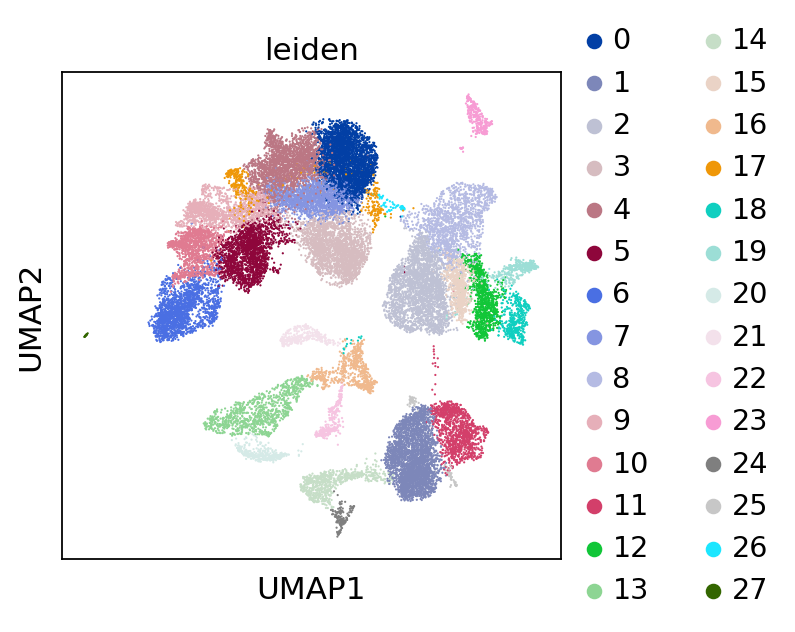

In [273]:
sc.pl.umap(adata, color=['leiden'])

In [274]:
!mkdir -p results

results_file = 'results/combined_MantonBM.h5ad'
adata.write(results_file)

In [275]:
#sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
#sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

/opt/conda/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/conda/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/conda/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result 

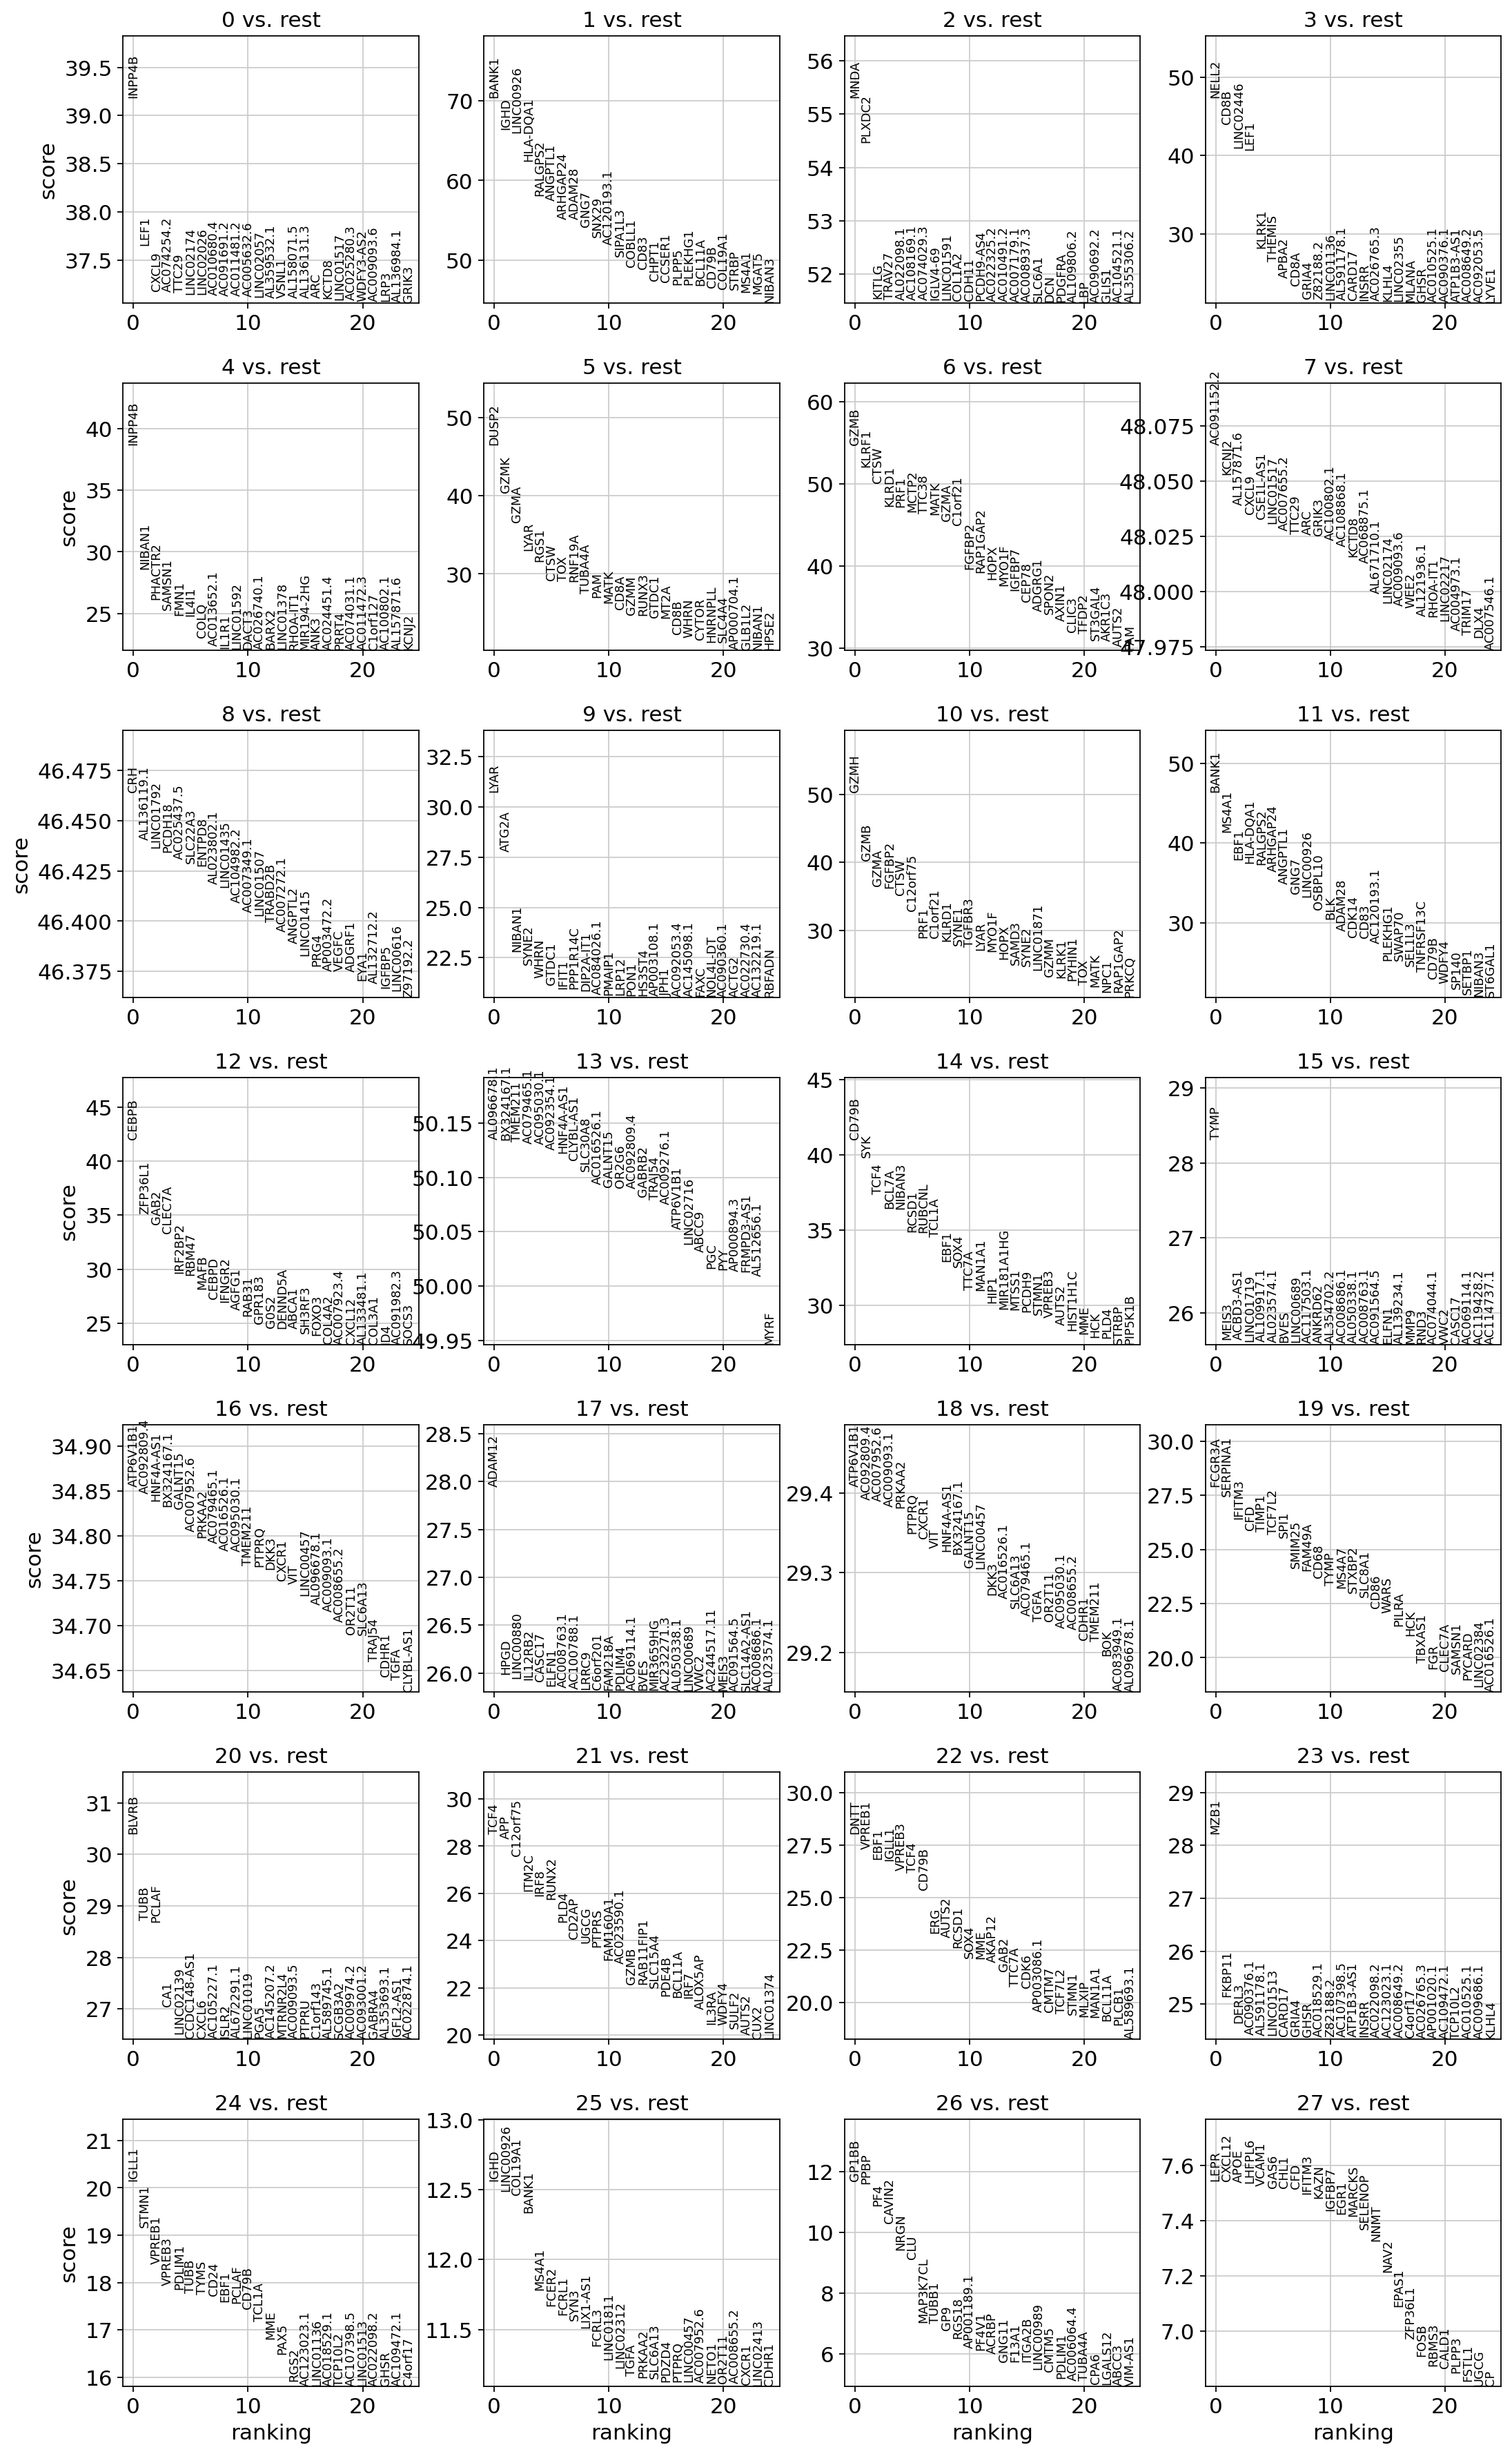

In [276]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [277]:
dedf = sc.get.rank_genes_groups_df(adata, group="0")
dedfup = dedf.head(20)
dedfdown = dedf.tail(20)
dedfup.names

0         INPP4B
1           LEF1
2          CXCL9
3     AC074254.2
4          TTC29
5      LINC02174
6      LINC02026
7     AC010680.4
8     AC091691.2
9     AC011481.2
10    AC005632.6
11     LINC02057
12    AL359532.1
13         VSNL1
14    AL158071.5
15    AL136131.3
16           ARC
17         KCTD8
18     LINC01517
19    AC025280.3
Name: names, dtype: object

TODO: Send each channel to it's own file and own plot